# Natural Language Processing

## Exercise Sheet 8

In [1]:
#imports for all exercises
import os
import nltk
import re
import pprint
import random
import itertools
import matplotlib.pyplot as plt
import nltk.classify as classify
import svgling
from collections import defaultdict
import nltk.grammar as grammar

from nltk.corpus import treebank

### Exercise 1

Write a recursive function to traverse a tree and return the depth of the tree, such that a tree with a single node would have depth zero. (Hint: the depth of a subtree is the maximum depth of its children, plus one.)
Test your function with the two trees produced by the `ChartParser` for the `groucho_grammar` and the sentence "I shot an elephant in my pajamas". The result can be verified with the `Tree.height()` function.



In [2]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
for tree in parser.parse(sent):
    print(tree)

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


In [3]:
def depth(t):
    if len(t) <= 1:
        return 0
    else:
        depths = []
        for child in t:
            depths.append(depth(child))
        
        return max(depths) + 1

In [4]:
for tree in parser.parse(sent):
    print(depth(tree))

4
5


In [5]:
for tree in parser.parse(sent):
    print(tree.height())

6
7


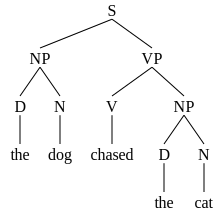

In [6]:
# single node ==> should return 0
single_node = nltk.Tree.fromstring('(S)')

# two children at same height ==> should return 1
height_one = nltk.Tree.fromstring('(S (NP I) (VP am))') 

# compare to drawing: tree should return a height of 3 if the first node is 0
doc = nltk.Tree.fromstring("(S (NP (D the) (N dog)) (VP (V chased) (NP (D the) (N cat))))") 
svgling.draw_tree(doc)

In [7]:
print("Recursive depth: ", depth(single_node))
print("Recursive depth: ", depth(height_one))
print("Recursive depth: ", depth(doc))
print("")
print("Tree.height(): ", single_node.height())
print("Tree.height(): ", height_one.height())
print("Tree.height(): ", doc.height())

Recursive depth:  0
Recursive depth:  1
Recursive depth:  3

Tree.height():  1
Tree.height():  3
Tree.height():  5


In this exercise, the task definition differs from what the documentation of ```nltk.Tree```'s ```height()``` method describes. Excerpt from the code documentation:

```
.
.
.
def height(self):
        """
        Return the height of the tree.

            >>> t = Tree.fromstring("(S (NP (D the) (N dog)) (VP (V chased) (NP (D the) (N cat))))")
            >>> t.height()
            5
            >>> print(t[0,0])
            (D the)
            >>> t[0,0].height()
            2

        :return: The height of this tree.  The height of a tree
            containing no children is 1; the height of a tree
            containing only leaves is 2; and the height of any other
            tree is one plus the maximum of its children's
            heights.
        :rtype: int
        """
        .
        .
        .
```

However, the task of exercise 1 states, that the recursive function should "return the depth of the tree, such that a tree with a single node would have depth zero. (Hint: the depth of a subtree is the maximum depth of its children, plus one.)". I decided to implement my version strictly to this task definition.

### Exercise 2

Write a recursive function `bracketing(tree)` that produces a nested bracketing for a `tree`, leaving out the leaf nodes, and displaying the non-terminal labels after their subtrees. Consecutive categories should be separated by space. Test your function with the tree: 

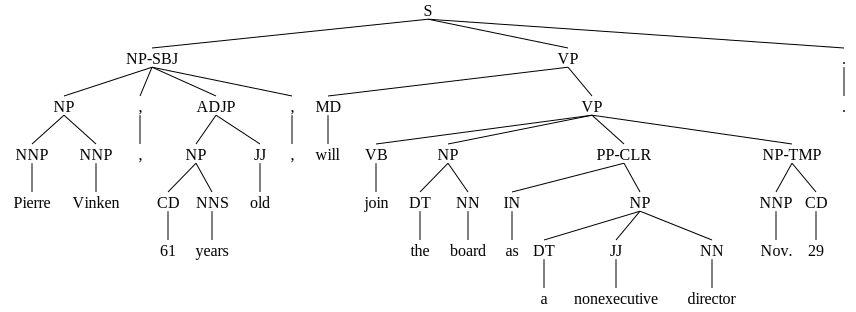

In [8]:
from nltk.corpus import treebank
tree = treebank.parsed_sents('wsj_0001.mrg')[0]
svgling.draw_tree(tree)

In [9]:
def bracketing(t):
    try:
        t.label()
    except AttributeError:
        print("", end="", sep="")
    else:
        if t.height() > 2:
            print("[", end="")
        for child in t:
            bracketing(child)
        if t.height() > 2:
            print("]", end="")
        
        print(t.label(), end=" ")

In [10]:
bracketing(tree)

[[[NNP NNP ]NP , [[CD NNS ]NP JJ ]ADJP , ]NP-SBJ [MD [VB [DT NN ]NP [IN [DT JJ NN ]NP ]PP-CLR [NNP CD ]NP-TMP ]VP ]VP . ]S 

    [[[NNP NNP]NP , [[CD NNS]NP JJ]ADJP ,]NP-SBJ [MD [VB [DT NN]NP 
    [IN [DT JJ NN]NP]PP-CLR [NNP CD]NP-TMP]VP]VP .]S

### Exercise 3

Modify the functions `init_wfst()` and `complete_wfst()` so that the contents of each cell in the WFST is a set of non-terminal symbols rather than a single non-terminal. Test your function with the `groucho_grammar` and the sentence "I shot an elephant in my pajamas". 

In [11]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']

def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    # Use empty set instead of None value
    wfst = [[set() for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        for production in productions:
            # query multiple productions
            #wfst[i][i+1] = productions[0].lhs()
            wfst[i][i+1].add(production.lhs()) # add to set
    return wfst

def complete_wfst(wfst, tokens, grammar, trace=False):
    #index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    #index = {p.rhs(): set([p.lhs()]) for p in grammar.productions()} #Does not work because set is not hashable
    
    index = defaultdict(set)
    for prod in grammar.productions():
        index[prod.rhs()].add(prod.lhs())
        
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                
                for key in itertools.product(nt1, nt2):
                    if key in index:
                        for combination in index[key]:
                            wfst[start][end].add(combination)
                    if trace:
                        for lhs in index[key]:
                            print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                            (start, nt1, mid, nt2, end, start, lhs, end))
                    
    return wfst

def display(wfst):
    print('\nWFST ' + ' '.join(("%-8d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-8s" % (wfst[i][j] or '.'), end=" ")
        print()

wfst0 = init_wfst(sent, groucho_grammar)
display(wfst0)
wfst = complete_wfst(wfst0, sent, groucho_grammar, True)
display(wfst)


WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        .        .        .        .        
1    .        {V}      .        .        .        .        .        
2    .        .        {Det}    .        .        .        .        
3    .        .        .        {N}      .        .        .        
4    .        .        .        .        {P}      .        .        
5    .        .        .        .        .        {Det}    .        
6    .        .        .        .        .        .        {N}      
[2] {Det} [3] {N} [4] ==> [2]  NP [4]
[5] {Det} [6] {N} [7] ==> [5]  NP [7]
[1] {V} [2] {NP} [4] ==> [1]  VP [4]
[4] {P} [5] {NP} [7] ==> [4]  PP [7]
[0] {NP} [1] {VP} [4] ==> [0]   S [4]
[1] {VP} [4] {PP} [7] ==> [1]  VP [7]
[0] {NP} [1] {VP} [7] ==> [0]   S [7]

WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        {S}      .        .        {S}      
1    .        {V}      .        {VP}     .    

Change the line:

    NP -> Det N | Det N PP | 'I' 

in `groucho_grammar` to:

    NP -> Det N | NP PP | 'I' 

to verify in the trace of `complete_wfst()` that there are now two lines for `cell(1,7)`:

    [1]   V [2]  NP [7] ==> [1]  VP [7]
    [1]  VP [4]  PP [7] ==> [1]  VP [7]

In [12]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | NP PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
wfst0 = init_wfst(sent, groucho_grammar)
display(wfst0)
wfst = complete_wfst(wfst0, sent, groucho_grammar, True)
display(wfst)


WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        .        .        .        .        
1    .        {V}      .        .        .        .        .        
2    .        .        {Det}    .        .        .        .        
3    .        .        .        {N}      .        .        .        
4    .        .        .        .        {P}      .        .        
5    .        .        .        .        .        {Det}    .        
6    .        .        .        .        .        .        {N}      
[2] {Det} [3] {N} [4] ==> [2]  NP [4]
[5] {Det} [6] {N} [7] ==> [5]  NP [7]
[1] {V} [2] {NP} [4] ==> [1]  VP [4]
[4] {P} [5] {NP} [7] ==> [4]  PP [7]
[0] {NP} [1] {VP} [4] ==> [0]   S [4]
[2] {NP} [4] {PP} [7] ==> [2]  NP [7]
[1] {V} [2] {NP} [7] ==> [1]  VP [7]
[1] {VP} [4] {PP} [7] ==> [1]  VP [7]
[0] {NP} [1] {VP} [7] ==> [0]   S [7]

WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        {S}     

Change the line:

    VP -> V NP | VP PP

in `groucho_grammar` to: 

    VP -> V NP
    VPC -> VP PP 

and check that `cell(1,7)` now contains `{VPC, VP}`.

In [13]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | NP PP | 'I'
VP -> V NP 
VPC -> VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
wfst0 = init_wfst(sent, groucho_grammar)
display(wfst0)
wfst = complete_wfst(wfst0, sent, groucho_grammar, True)
display(wfst)


WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        .        .        .        .        
1    .        {V}      .        .        .        .        .        
2    .        .        {Det}    .        .        .        .        
3    .        .        .        {N}      .        .        .        
4    .        .        .        .        {P}      .        .        
5    .        .        .        .        .        {Det}    .        
6    .        .        .        .        .        .        {N}      
[2] {Det} [3] {N} [4] ==> [2]  NP [4]
[5] {Det} [6] {N} [7] ==> [5]  NP [7]
[1] {V} [2] {NP} [4] ==> [1]  VP [4]
[4] {P} [5] {NP} [7] ==> [4]  PP [7]
[0] {NP} [1] {VP} [4] ==> [0]   S [4]
[2] {NP} [4] {PP} [7] ==> [2]  NP [7]
[1] {V} [2] {NP} [7] ==> [1]  VP [7]
[1] {VP} [4] {PP} [7] ==> [1] VPC [7]
[0] {NP} [1] {VP, VPC} [7] ==> [0]   S [7]

WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        {S}

Finally, change the line:

    S -> NP VP

in `groucho_grammar` to:

    S -> NP VP | NP VPC

and check that now there are two lines in the trace of `complete_wfst()` for the `cell(0,7)`:

    [0]  NP [1] VPC [7] ==> [0]   S [7]
    [0]  NP [1]  VP [7] ==> [0]   S [7]

In [14]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP | NP VPC
PP -> P NP
NP -> Det N | NP PP | 'I'
VP -> V NP 
VPC -> VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
wfst0 = init_wfst(sent, groucho_grammar)
display(wfst0)
wfst = complete_wfst(wfst0, sent, groucho_grammar, True)
display(wfst)


WFST 1        2        3        4        5        6        7       
0    {NP}     .        .        .        .        .        .        
1    .        {V}      .        .        .        .        .        
2    .        .        {Det}    .        .        .        .        
3    .        .        .        {N}      .        .        .        
4    .        .        .        .        {P}      .        .        
5    .        .        .        .        .        {Det}    .        
6    .        .        .        .        .        .        {N}      
[2] {Det} [3] {N} [4] ==> [2]  NP [4]
[5] {Det} [6] {N} [7] ==> [5]  NP [7]
[1] {V} [2] {NP} [4] ==> [1]  VP [4]
[4] {P} [5] {NP} [7] ==> [4]  PP [7]
[0] {NP} [1] {VP} [4] ==> [0]   S [4]
[2] {NP} [4] {PP} [7] ==> [2]  NP [7]
[1] {V} [2] {NP} [7] ==> [1]  VP [7]
[1] {VP} [4] {PP} [7] ==> [1] VPC [7]
[0] {NP} [1] {VP, VPC} [7] ==> [0]   S [7]
[0] {NP} [1] {VP, VPC} [7] ==> [0]   S [7]

WFST 1        2        3        4        5        6        7

### Exercise 4

Modify the function `complete_wfst()` from Exercise 3 so that when a non-terminal symbol is added to a cell in the WFST, the content of the variable `mid` is also added, i.e. we add a tuple `(symbol, mid)`. In `init_wfst()`, use `(symbol, i+1)` instead. Change also the function `display()` accordingly. Test your implementation with the final grammar from Exercise 3 and the sentence "I shot an elephant in my pajamas". 

In [15]:
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    # Use empty set instead of None value
    wfst = [[set() for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        for production in productions:
            # query multiple productions and add i+1 as column number
            wfst[i][i+1].add((production.lhs(), i+1)) # add to set
    return wfst

def complete_wfst(wfst, tokens, grammar, trace=False):
    index = defaultdict(set)
    for prod in grammar.productions():
        index[prod.rhs()].add(prod.lhs())
        
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                
                for key in itertools.product(nt1, nt2):
                    # Update according to new scheme (symbol, mid)
                    key = tuple((term[0] for term in key))
                    if key in index:
                        for combination in index[key]:
                            wfst[start][end].add((combination, mid))
                    if trace:
                        for lhs in index[key]:
                            print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                            (start, nt1, mid, nt2, end, start, lhs, end))
                    
    return wfst

def display(wfst):
    print('\nWFST ' + ' '.join(("%-12d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-12s" % (wfst[i][j] or '.'), end=" ")
        print()

wfst0 = init_wfst(sent, groucho_grammar)
display(wfst0)
wfst = complete_wfst(wfst0, sent, groucho_grammar, True)
display(wfst)


WFST 1            2            3            4            5            6            7           
0    {(NP, 1)}    .            .            .            .            .            .            
1    .            {(V, 2)}     .            .            .            .            .            
2    .            .            {(Det, 3)}   .            .            .            .            
3    .            .            .            {(N, 4)}     .            .            .            
4    .            .            .            .            {(P, 5)}     .            .            
5    .            .            .            .            .            {(Det, 6)}   .            
6    .            .            .            .            .            .            {(N, 7)}     
[2] {(Det, 3)} [3] {(N, 4)} [4] ==> [2]  NP [4]
[5] {(Det, 6)} [6] {(N, 7)} [7] ==> [5]  NP [7]
[1] {(V, 2)} [2] {(NP, 3)} [4] ==> [1]  VP [4]
[4] {(P, 5)} [5] {(NP, 6)} [7] ==> [4]  PP [7]
[0] {(NP, 1)} [1] {(VP, 2)} [4] ==

It should produce the following output:

    WFST      1          2          3          4          5          6          7         
    0         {(NP, 1)}  .          .          {(S, 1)}   .          .          {(S, 1)}   
    1         .          {(V, 2)}   .          {(VP, 2)}  .          .          {(VP, 2), (VPC, 4)} 
    2         .          .          {(Det, 3)} {(NP, 3)}  .          .          {(NP, 4)}  
    3         .          .          .          {(N, 4)}   .          .          .          
    4         .          .          .          .          {(P, 5)}   .          {(PP, 5)}  
    5         .          .          .          .          .          {(Det, 6)} {(NP, 6)}  
    6         .          .          .          .          .          .          {(N, 7)}    

In [16]:
len(wfst[3][7])

0

### Exercise 5

Use the extended WFST from Exercise 4 to retrace the parse trees for our example sentence "I shot an elephant in my pajamas''. Write a recursive function `retrace(WFST, tokens)` (the 
second parameter `tokens` contains the token list \['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas'\] for our example sentence). Start with `cell(0,7)` (or `cell(0,len(tokens))` in general) and use the information in `mid` to follow the productions to `cell(0,mid)` and `cell(mid,7)`, and so on. If we reach a terminal symbol, i.e. a `cell(i,i+1)`, the corresponding token from `tokens` shall be displayed. 

In [17]:
def retrace(WFST, tokens, start=0, end=7):
    try:
        cell = list(WFST[start][end])
    except IndexError:
        print("")
    else:
        if len(cell) == 0:
            retrace(WFST, tokens, start=start, end=end-1)
        else:
            if start + 1 == end:
                for prod in cell:
                    print("%-4s->" % prod[0], end=" ")
                    print(tokens[start])
                    print(end*"\t", end="")
                    mid = prod[1]

                retrace(WFST, tokens, start=mid, end=len(tokens))
            else:
                for prod in cell:
                    print("%-4s->" % prod[0], end=" ")
                    retrace(WFST, tokens, start=start, end=prod[1])
    
    
retrace(wfst, sent)

S   -> NP  -> I
	VP  -> V   -> shot
		NP  -> NP  -> Det -> an
			N   -> elephant
				PP  -> P   -> in
					NP  -> Det -> my
						N   -> pajamas
							
VPC -> VP  -> V   -> shot
		NP  -> NP  -> Det -> an
			N   -> elephant
				PP  -> P   -> in
					NP  -> Det -> my
						N   -> pajamas
							


The function should produce the following output:

    S    -> NP   -> I 
            VPC  -> VP   -> V    -> shot 
                            NP   -> Det  -> an 
                                    N    -> elephant 
                    PP   -> P    -> in 
                            NP   -> Det  -> my 
                                    N    -> pajamas 
            VP   -> V    -> shot 
                    NP   -> NP   -> Det  -> an 
                                    N    -> elephant 
                            PP   -> P    -> in 
                                    NP   -> Det  -> my 
                                            N    -> pajamas  

### Exercise 6

Process each tree of the Penn Treebank Corpus sample `nltk.corpus.treebank` and extract the productions with the help of `Tree.productions()`. Discard the productions that occur only once and those that are lexical (i.e. the right-hand side contains at least one terminal token). Productions with the same left-hand side can be collapsed using a dictionary with the left-hand sides as keys and sets of right-hand sides as values.

Print the value for the left-hand side 'NP' using the format: 

    DT JJS NN NN | DT VBG NN NN | DT NNP CD NN | DT NN NNS ...


In [18]:
def extract_grammar(sents):
    prods = []
    for sent in sents:
        prods = prods + sent.productions()

    freq = nltk.FreqDist(prods) # Distribution of productions key: rule, value: number of occurrences  
    prods = [key for (key, value) in freq.items() if value > 1] # Discard the productions that occur only once
    
    return nltk.CFG(start = grammar.Nonterminal('S'), productions=prods)
    
gr = extract_grammar(treebank.parsed_sents())

In [19]:
lhs_NP = [p.rhs() for p in gr.productions()]
type(lhs_NP[0][0])

nltk.grammar.Nonterminal

In [20]:
lhs_NP = {p.lhs: p.rhs() for p in gr.productions() if p.lhs() == grammar.Nonterminal('NP') and len([el for el in p.rhs() if type(el) == str]) == 0}

for rule in lhs_NP.values():
    for nonterminal in rule:
        print(nonterminal, end=" ")
    print("| ", end="")

NNP NNP | CD NNS | DT NN | DT JJ NN | NN | NP , NP | NP PP | JJ NN | NNP NNP NNP NNP | DT JJ JJ NN | -NONE- | NNP NN NNS | NP PP PP-LOC | NN NNS | NP RRC | NNS | PRP | QP NNS | DT NN NN | DT NNS | RB JJ NNS | NP SBAR | NP PP SBAR | ADJP NNP NNP | NNP NNS | PRP$ NN NN NNS | CD | QP NN | NP NNP NNP NNP | NN POS | NNP | NP ADJP | DT JJ NNS | PRP$ NNS | DT NNP NNS | NNP NNP NNP | NNP POS | NP PP-DIR | NP CC NP | DT NNP NNP NNP | ADJP NNS | DT JJ CD | QP NNP NNS | JJ NNS | ADJP NN | NP , NP CC NP | NN NN | DT | NN NN NNS | NP PP-LOC | DT NAC-LOC NN NN | DT JJS | DT NN NNS | JJ VBN NNS | NP PP S-2 | NN S | NP PP PP | NP VP | NP PP , NP , | JJS NNS | DT JJ VBN NNS | DT JJR NN | DT JJ , JJ NNS | DT NAC NNP | DT CD | JJ NN NNS | DT VBN NN | NN CC NN NNS | DT NNS CC NNS | NNP CC NNP | NP NP-TMP | PRP$ NN NN | JJ JJ NNS | NNS SBAR | DT JJ JJ NN NN | DT CD JJ NNS | CD NN | NP NNS | DT NNS POS | NP , NP , | NP PP-TMP | JJ NNP | VBG NN NNS | VBG NNS | JJR NNS | NP PRN | JJ NNP NNS | NP NN | QP -NONE